In [1]:
import copy

import torch
from kan import KAN

# Unsupervised Learning
In this test we try to solve an unsupervised learning problem. The data set consists of 7 variables with the following relationships:
- $x_2=sin(6x_0)+e^{2x_1}$
- $x_6=4x_3+x_4+x_5$

KAN must discover these relationships based only on the value of these variables.

## What is the best way forward?
We could try to split the variables into two partitions, one for the dependent variable and the other for the independent variable(s). This would bring us back to supervised learning. However, this is computationally expensive, since $2^7-2$ different symbolic regression tasks would have to be considered.

The authors devised a different approach that avoids the combinatorial explosion:
1. We label all our points as 1.
2. We add corrupted points, and label them as 0. Corruption is achieved by randomly permuting each feature to avoid hindering the original dataset topology.
3. We solve a regression problem on the data set created in this way.

## How to read the result?

The solution function should be:
$$g: \begin{cases}
g(x_{real})=1\\
g(x_{fake})=0
\end{cases} $$

Which is not exactly what we want:
$$f: \begin{cases}
f(x_{real})=0\\
f(x_{fake})\neq0
\end{cases} $$

Therefore, we add one extra final KAN layer and fix it with the Gaussian function $\sigma(x)=e^{-\frac{x^2}{2\omega^2}}$, with $\omega$ a small variance. This implies that $g=\sigma\circ f$

In [2]:
def create_dataset(train_num=1000, test_num=500):
    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:, 2] = torch.sin(6 * x[:, 0]) + torch.exp(2 * x[:, 1])
        x[:, 6] = 4 * x[:, 3] + x[:, 4] + x[:, 5]

        # negative samples
        x_cor = copy.deepcopy(x)
        for i in range(x_cor.shape[1]):
            x_cor[:, i] = x_cor[:, i][torch.randperm(x_cor.shape[0])]

        inputs = torch.cat([x, x_cor], dim=0)
        labels = torch.cat([torch.ones(batch, ), torch.zeros(batch, )], dim=0)[:, None]
        return inputs, labels

    x = torch.rand(train_num, 7) * 2 - 1
    x_train, y_train = generate_contrastive(x)

    x = torch.rand(test_num, 7) * 2 - 1
    x_test, y_test = generate_contrastive(x)

    dataset = {'train_input': x_train, 'test_input': x_test, 'train_label': y_train, 'test_label': y_test}
    return dataset


dataset = create_dataset()

# First equation
The model, with almost any seed, easily finds the equation $f(x_3,x_4,x_5,x_6)=4x_3+x_4+x_5-x_6=0$.

We know for sure that the model has found a valid relationship when the loss decreases a lot. Of course, we always have the regularization penalty that prevents the total loss from becoming too small.

In [14]:
model = KAN(width=[7, 1, 1], grid=3, k=3)
model.fix_symbolic(1, 0, 0, 'gaussian', fit_params_bool=False)

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


| train_loss: 1.76e-01 | test_loss: 1.85e-01 | reg: 8.24e+00 | : 100%|█| 30/30 [00:04<00:00,  7.21it


saving model version 0.6


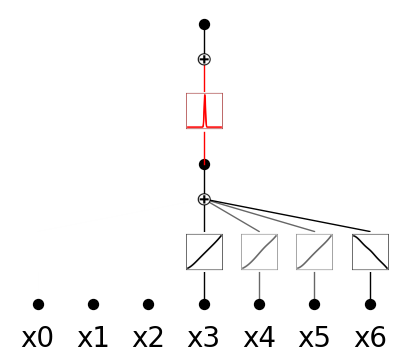

In [19]:
model.fit(dataset, opt="LBFGS", steps=30, lamb=0.01, lamb_entropy=4.0)
model.plot(in_vars=['x0','x1','x2','x3','x4','x5','x6'], scale=.5)

# Second equation
To find the other relationship, we could try different seeds until the KAN finds a different configuration. This is what the paper actually does.

However, since the relationship $f(x_0,x_1,x_2)=sin(6x_0)+e^{2x_1}-x_2=0$ is much harder to find the other one, we could use a clever trick. Using the prior knowledge that the relations do not have overlapping variables, we deactivate the edges of the variables $x_3,x_4,x_5,x_6$ and then train the KAN from scratch.

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
saving model version 0.2
saving model version 0.3
saving model version 0.4
saving model version 0.5


| train_loss: 1.87e-01 | test_loss: 1.89e-01 | reg: 9.89e+00 | : 100%|█| 40/40 [00:17<00:00,  2.33it


saving model version 0.6


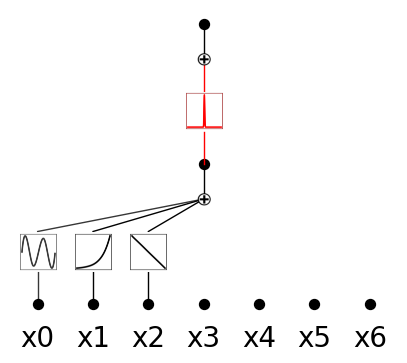

In [22]:
model = KAN(width=[7, 1, 1], grid=3, k=3)
model.fix_symbolic(1, 0, 0, 'gaussian', fit_params_bool=False)
for l, i, j in [(0, 3, 0), (0, 4, 0), (0, 5, 0), (0, 6, 0)]:
    model.fix_symbolic(l, i, j, '0', fit_params_bool=False)
model.fit(dataset, opt="LBFGS", steps=40, lamb=0.0001, lamb_entropy=4.0)
model.plot(in_vars=['x0','x1','x2','x3','x4','x5','x6'], scale=.5)


saving model version 0.7
fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,1,0) with exp, r2=0.9999653697013855, c=2
fixing (0,2,0) with x, r2=0.9998946189880371, c=1
skipping (0,3,0) since already symbolic
skipping (0,4,0) since already symbolic
skipping (0,5,0) since already symbolic
skipping (0,6,0) since already symbolic
skipping (1,0,0) since already symbolic
saving model version 0.7


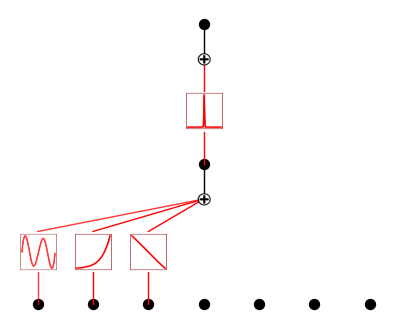

In [11]:
model.prune()
model.auto_symbolic()
model.plot()